## A simple neural translation model without attention mechanism


In [0]:
# getting the data

!wget --header="Host: www.manythings.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "http://www.manythings.org/anki/deu-eng.zip" -c -O 'deu-eng.zip'

--2020-05-13 15:35:08--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:3033::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7876575 (7.5M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   7.51M  6.00MB/s    in 1.3s    

2020-05-13 15:35:10 (6.00 MB/s) - ‘deu-eng.zip’ saved [7876575/7876575]



In [0]:
!unzip /content/deu-eng.zip

Archive:  /content/deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
data = pd.read_csv("deu.txt", sep = "\t") # its a tab sep file
data.head()

,Go.,Geh.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)
0,Hi.,Hallo!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1,Hi.,Grüß Gott!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Run!,Lauf!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
3,Run.,Lauf!,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
4,Wow!,Potzdonner!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [0]:
import re

[A guide to unicode, utf-8 and ascii](https://towardsdatascience.com/a-guide-to-unicode-utf-8-and-strings-in-python-757a232db95c)

check the link for info on topics above 

### Text preprocessing

In [0]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array

# load doc into memory
def load_doc(filename):
	# open the file as read only
    file = open("deu.txt", "rt", encoding = "utf-8")
    text = file.read()
    file.close()
    return text

# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs



In [0]:
# clean a list of lines
def clean_pairs(pairs):
    cleaned = []
    # creating translation mapping for removing the punctuations
    trans_table = str.maketrans("", "", string.punctuation)

    for pair in pairs:
        clean_pair = []
        for line in pair:

            # conv into ascii (to conv non english chars to emglish)
            line = unicodedata.normalize("NFD", line)
            line = line.encode("ascii", "ignore")

            # conv it back to utf (python3 runs on unicode)
            line = line.decode("UTF-8")

            # split each word in the sentence on whitespace
            line = line.split()

            # conv to lowercase
            line = [word.lower() for word in line]

            # remove puntuations from each word
            line = [word.translate(trans_table) for word in line]

            # remove numbers
            line = [word for word in line if word.isalpha()]

            # join all the single elems in "line" into a single string
            line = " ".join(line)

            # append each sentance as elems of list
            clean_pair.append(line)
            # clean_pair_arr = np.array(clean_pair)

        # append the above list as an elem of list
        cleaned.append(clean_pair)

    # dealing with mismatching no of elems in the list inside list

    max_elems = 3

    # pad "none" for all the missing list elems
    cleaned_new = [ls + [None]*(max_elems - len(ls)) for ls in cleaned]

    return np.array(cleaned_new)


In [0]:
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
filename = 'deu.txt'
doc = load_doc(filename)

# split into english-german pairs
pairs = to_pairs(doc)

# clean sentences
clean_pairs = clean_pairs(pairs)

# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')

# view some x--y pairs
for i in range(25):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[go] => [geh]
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[wait] => [warte]
[begin] => [fang an]
[go on] => [mach weiter]
[hello] => [hallo]
[hurry] => [beeil dich]
[hurry] => [schnell]
[i ran] => [ich rannte]
[i see] => [ich verstehe]
[i see] => [aha]
[i try] => [ich probiere es]
[i won] => [ich hab gewonnen]
[i won] => [ich habe gewonnen]
[relax] => [entspann dich]


In [0]:
# checking last few sentences
clean_pairs[-2, 0] #its very huge

'doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people and out of the few hundred that there are but a dozen or less whom he knows intimately and out of the dozen one or two friends at most it will easily be seen when we remember the number of millions who inhabit this world that probably since the earth was created the right man has never yet met the right woman'


### Analysis:
* The complexity of the pairs increases with the number of examples
* we will simplify the problem slightly to dramatically reduce the size of the model required, and in turn the training time required to fit the model.
* we will just take the first 10k samples and use 9k for training and 1k for test

In [0]:
dataset = clean_pairs[:10000, :]

np.random.shuffle(dataset)
train_data = dataset[: 9000]
test_data = dataset[9000 : ]

In [0]:
# lets create the tokenizer

from tensorflow.keras.preprocessing.text import Tokenizer

In [0]:
# creating the tokenizer and fitting on eng data
def create_tokenizer(lang_data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lang_data)
    return tokenizer

In [0]:
# creating eng and german tokenizers
eng_tokenizer = create_tokenizer(dataset[:, 0])
ger_tokenizer = create_tokenizer(dataset[:, 1])
# return a tokenizer obj

In [0]:
print(ger_tokenizer.word_index)

{'ich': 1, 'tom': 2, 'ist': 3, 'sie': 4, 'es': 5, 'das': 6, 'bin': 7, 'wir': 8, 'nicht': 9, 'hat': 10, 'du': 11, 'er': 12, 'habe': 13, 'mich': 14, 'ein': 15, 'zu': 16, 'sind': 17, 'war': 18, 'mir': 19, 'dich': 20, 'auf': 21, 'wer': 22, 'uns': 23, 'die': 24, 'kann': 25, 'sich': 26, 'ihr': 27, 'haben': 28, 'bist': 29, 'an': 30, 'werde': 31, 'hier': 32, 'eine': 33, 'gehen': 34, 'gut': 35, 'ihn': 36, 'wird': 37, 'einen': 38, 'was': 39, 'aus': 40, 'in': 41, 'mag': 42, 'lass': 43, 'dir': 44, 'wie': 45, 'mal': 46, 'mach': 47, 'werden': 48, 'liebe': 49, 'mein': 50, 'euch': 51, 'geht': 52, 'den': 53, 'wurde': 54, 'komm': 55, 'da': 56, 'mit': 57, 'hause': 58, 'nach': 59, 'jetzt': 60, 'der': 61, 'geh': 62, 'will': 63, 'sein': 64, 'konnen': 65, 'kommen': 66, 'fur': 67, 'bitte': 68, 'seid': 69, 'so': 70, 'meine': 71, 'beschaftigt': 72, 'gesehen': 73, 'gerade': 74, 'weg': 75, 'machen': 76, 'hast': 77, 'einfach': 78, 'tun': 79, 'sehr': 80, 'macht': 81, 'darf': 82, 'hatte': 83, 'hasse': 84, 'ab': 85, 

In [0]:
# finidng the max len of a seq in a langauge
def max_len(lang_data):
    return max([len(line.split()) for line in lang_data])


In [0]:
# max len of both eng and ger
eng_len = max_len(dataset[:, 0])
ger_len = max_len(dataset[:, 1])

print(eng_len, ger_len, sep = "\n")

5
9


In [0]:
# finding the no of elems in each lang's vocab
eng_vocab_size = len(eng_tokenizer.word_counts) + 1
print(eng_vocab_size)
ger_vocab_size = len(ger_tokenizer.word_counts) + 1
print(ger_vocab_size) 

2214
3526


Each input and output sequence must be encoded to integers
 and padded to the maximum phrase length

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# preparing the encodings 
x = ger_tokenizer.texts_to_sequences(dataset[:, 1])
print(dataset[0, 1]) # first line in ger
print(x[0]) # relevant encoding before pad

# padding each sentance(samples) with zeros to max len
x = pad_sequences(x, maxlen = ger_len, padding= "post")
print(x[0])

ich bin wieder zuhause
[1, 7, 147, 266]
[  1   7 147 266   0   0   0   0   0]


In [0]:
def encode_seq(tokenizer, lang_data, lang_len):
    x = tokenizer.texts_to_sequences(lang_data)
    x = pad_sequences(x, maxlen = lang_len, padding = "post")
    return x

In [0]:
# creating encodings for both training and test data
""" x --> german
    y --> english """

train_x = encode_seq(ger_tokenizer, train_data[:, 1], ger_len)
train_y = encode_seq(eng_tokenizer, train_data[:, 0], eng_len)

test_x = encode_seq(ger_tokenizer, test_data[:, 1], ger_len)
test_y = encode_seq(eng_tokenizer, test_data[:, 0], eng_len)

In [0]:
train_x[:3] # checking the encodings and pads

array([[  1,   7, 147, 266,   0,   0,   0,   0,   0],
       [249, 250,   0,   0,   0,   0,   0,   0,   0],
       [ 12, 198, 166,  16,  64,   0,   0,   0,   0]], dtype=int32)

In [0]:
from tensorflow.keras.utils import to_categorical

In [0]:
# now for one hot encoding all the words in english
y_list = []
for sample in train_y:
    print(sample)
    print(to_categorical(sample, num_classes = eng_vocab_size))
    break

""" shape of encodings :
    axis[0] --> rows = 5 (max no of words in a sample for eng)
    axis[1] --> cols = vocab size (the tot no of words in that lang) """

[ 7 88 49  0  0]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


' shape of encodings :\n    axis[0] --> rows = 5 (max no of words in a sample for eng)\n    axis[1] --> cols = vocab size (the tot no of words in that lang)'

In [0]:
train_y.shape

(9000, 5)

In [0]:
def encode_op(label_data, vocab_size):
    y_list = []
    for sample in label_data:
        encoded = to_categorical(sample, num_classes= vocab_size)
        y_list.append(encoded)
    y = np.array(y_list)
    y = y.reshape(label_data.shape[0], label_data.shape[1], vocab_size)
    return y

In [0]:
train_y_one_h = encode_op(train_y, eng_vocab_size)
print(train_y_one_h.shape)

test_y_one_h = encode_op(test_y, eng_vocab_size)
print(test_y_one_h.shape)

(9000, 5, 2214)
(1000, 5, 2214)


### Building the encoder - decoder model


[learning about tensor shapes as input and output to an rnn](https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e)


In [0]:
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model

#### Layers and functions

```
feature_units = 256 
# the no of features assigned for a single word in the emb
input_shape = (ger_len, feature_units)
# (timestep/ seq len, features)


emb = Embedding(input_dim = ger_vocab_size, output_dim = feature_units,
              mask_zero = True, input_length = ger_len)
inputs = Input(shape = input_shape)
x = LSTM(units = feature_units)(inputs)
# units is the arg that gives
# the no of features given out by lstm
x = RepeatVector(n = eng_len)(x) 
# repeats the input for eng timesteps
# ie, eng's no of words in a seq
x = LSTM(units = feature_units, return_sequences = True)(x)
x = TimeDistributed(Dense(eng_vocab_size, activation = "softmax"))(x)
# returns a softmax emb of size = eng_vocab

translator = Model(inputs = inputs, outputs = x)
translator.summary()
```



In [0]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

In [0]:
model = define_model(ger_vocab_size, eng_vocab_size, 
                     ger_len, eng_len, 256)
model.compile(loss = "categorical_crossentropy", optimizer = "adam")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 9, 256)            902656    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 2214)           568998    
Total params: 2,522,278
Trainable params: 2,522,278
Non-trainable params: 0
_________________________________________________________________


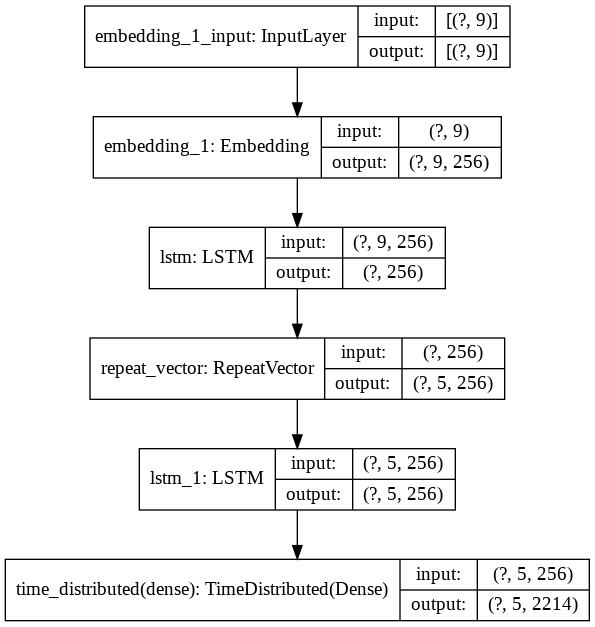

In [0]:
plot_model(model, to_file = "model.png", show_shapes = True)

In [0]:
model_name = "model.h5"
model_saves = ModelCheckpoint(model_name, monitor = "val_loss",
                               verbose = 1, save_best_only = True)
model.fit(train_x, train_y_one_h, epochs = 50,
          batch_size = 64, validation_data = (test_x, test_y_one_h),
          callbacks = [model_saves])

Epoch 1/50
139/141 [============================>.] - ETA: 0s - loss: 4.1473
Epoch 00001: val_loss improved from inf to 3.41298, saving model to model.h5
141/141 [==============================] - 4s 28ms/step - loss: 4.1389 - val_loss: 3.4130
Epoch 2/50
139/141 [============================>.] - ETA: 0s - loss: 3.2418
Epoch 00002: val_loss improved from 3.41298 to 3.26655, saving model to model.h5
141/141 [==============================] - 3s 19ms/step - loss: 3.2409 - val_loss: 3.2665
Epoch 3/50
139/141 [============================>.] - ETA: 0s - loss: 3.1036
Epoch 00003: val_loss improved from 3.26655 to 3.19657, saving model to model.h5
141/141 [==============================] - 3s 19ms/step - loss: 3.1038 - val_loss: 3.1966
Epoch 4/50
141/141 [==============================] - ETA: 0s - loss: 2.9905
Epoch 00004: val_loss improved from 3.19657 to 3.09253, saving model to model.h5
141/141 [==============================] - 3s 19ms/step - loss: 2.9905 - val_loss: 3.0925
Epoch 5/50
1

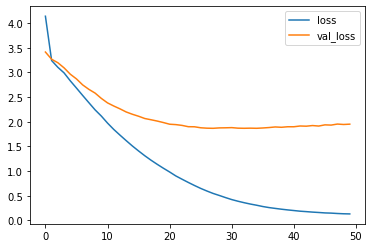

In [0]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [0]:
translation = model.predict(train_x, verbose = 0)[0] # for one sample
print(translation)
translation.shape

[[3.51494382e-05 2.11752340e-04 1.86912492e-02 ... 3.34539840e-09
  1.98537853e-09 1.91295779e-09]
 [9.41113249e-05 5.34593312e-08 1.04369654e-07 ... 6.42742526e-09
  3.83912591e-09 4.54799265e-09]
 [1.37529492e-01 1.69800956e-07 2.62776751e-07 ... 5.72029535e-10
  4.76929607e-10 5.32927869e-10]
 [9.82065976e-01 2.23451355e-08 6.29964658e-09 ... 1.12088091e-11
  6.77040628e-12 9.27482830e-12]
 [9.99955177e-01 1.42532097e-09 2.22852889e-10 ... 2.04236706e-13
  1.18797577e-13 1.50177641e-13]]


(5, 2214)

In [0]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if integer == index:
            return word
    return None

In [0]:
def predict_sequence(model, tokenizer, sample):
	sample = sample.reshape(1, sample.shape[0])
	prediction = model.predict(sample, verbose=0)[0]
	integers = [np.argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = idx_to_word(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

In [0]:
from nltk.translate.bleu_score import corpus_bleu

In [0]:
# putting the above in a function:
def evaluate_model(model, tokenizer, raw_data, source_data):

    actual, predicted = [], []
    # get translation for each sample
    for i, sample in enumerate(source_data):
        translation = predict_sequence(model, tokenizer, sample)
        # get corresponding source and true translation:
        raw_target, raw_source = raw_data[i, :2]
        # print few of the predictions:
        if i < 15:
            print("source = [{}], target = [{}], pred = [{}]".format(raw_source, raw_target, translation))
        
        # store original translation and pred translation for scoring
        actual.append([raw_target.split()])
        predicted.append(translation.split())
        


    # cal bleu score:
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


In [0]:
# now evaluate model 

# on training samples:
print("training predictions")
evaluate_model(model, eng_tokenizer, train_data, train_x)

# on testing samples:
print("test")
evaluate_model(model, eng_tokenizer, test_data, test_x)


training predictions
source = [ich bin wieder zuhause], target = [im back home], pred = [im back home]
source = [zum wohl], target = [cheers], pred = [cheers]
source = [er scheint mude zu sein], target = [he seems tired], pred = [he seems tired]
source = [schneide es in zwei halften], target = [cut it in half], pred = [cut it in half]
source = [jetzt schuldest du mir etwas], target = [now you owe me], pred = [now you owe me]
source = [wer will es], target = [who wants it], pred = [who wants it]
source = [kennen wir dich], target = [do we know you], pred = [do we know you]
source = [er war bekifft], target = [he was stoned], pred = [he was stoned]
source = [tom baut reis an], target = [tom grows rice], pred = [tom grows rice]
source = [leg ihm handschellen an], target = [cuff him], pred = [cuff him]
source = [das tut weh], target = [that hurts], pred = [that hurts]
source = [besser], target = [thats better], pred = [thats better]
source = [tom ist zuruckgetreten], target = [toms resigne